# Variational Quantum EigenSolver (VQE) for the Hydrogen Molecule

In [1]:
# !pip install openfermion pyscf openfermionpyscf

In [2]:
import openfermion.chem as of_chem
import openfermion.transforms as of_trans
import openfermionpyscf as of_pyscf

In [3]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance = 0.977
geometry = [["H", [0, 0, 0]], ["H", [0, 0, distance]]]
description = "tmp"
molecule = of_chem.MolecularData(geometry, basis, multiplicity, charge, description)
molecule = of_pyscf.run_pyscf(molecule, run_scf=True, run_fci=True)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = of_trans.get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = of_trans.jordan_wigner(fermionic_hamiltonian)

## Convert to Qamomile Hamiltonian

In [37]:
import qamomile.core.operator as qm_o

def operator_to_qamomile(operators: tuple[tuple[int, str], ...]) -> qm_o.Hamiltonian:
    pauli = {"X": qm_o.X, "Y": qm_o.Y, "Z": qm_o.Z}
    H = qm_o.Hamiltonian()
    H.constant = 1.0
    for ope in operators:
        H = H * pauli[ope[1]](ope[0])
    return H

def openfermion_to_qamomile(of_h) -> qm_o.Hamiltonian:
    H = qm_o.Hamiltonian()
    for k, v in of_h.terms.items():
        if len(k) == 0:
            H.constant += v
        else:
            H += operator_to_qamomile(k) * v
    return H

hamiltonian = openfermion_to_qamomile(jw_hamiltonian)

## Create VQE ansatz

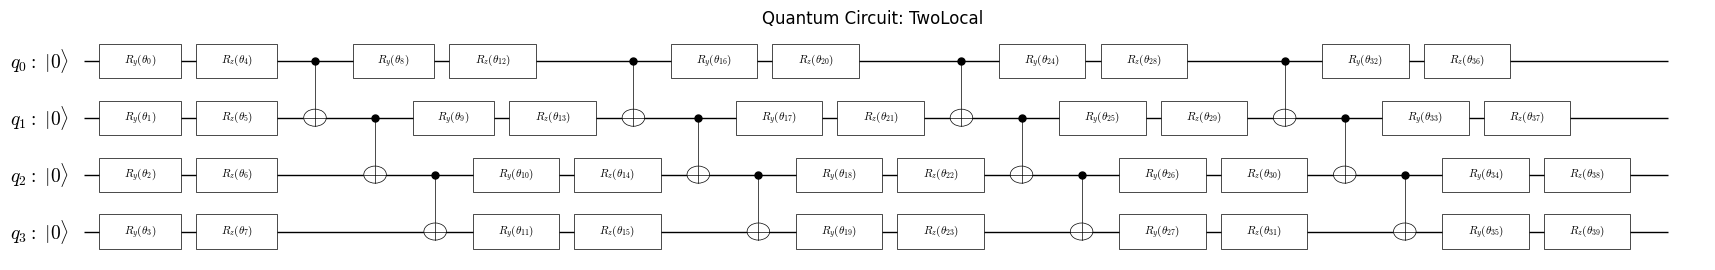

In [49]:
from qamomile.core.ansatz.efficient_su2 import create_efficient_su2_circuit
from qamomile.core.circuit.drawer import plot_quantum_circuit

ansatz = create_efficient_su2_circuit(
    hamiltonian.num_qubits, rotation_blocks=["ry", "rz"],
    reps=4, entanglement="linear"
)
plot_quantum_circuit(ansatz)

## Run VQE with Qiskit

In [50]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()
qk_ansatz = qk_transpiler.transpile_circuit(ansatz)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(hamiltonian)

In [57]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []


def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_ansatz, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data["evs"] + hamiltonian.constant.real
    cost_history.append(cost)
    return cost


initial_params = np.random.uniform(0, np.pi, len(qk_ansatz.parameters))

# Run QAOA optimization
result = minimize(
    cost_estimator,
    initial_params,
    method="BFGS",
    options={"disp": True, "maxiter": 50, "gtol": 1e-6},
)
print(result)

         Current function value: -1.105897
         Iterations: 50
         Function evaluations: 2132
         Gradient evaluations: 52
  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: -1.1058970882676094
        x: [ 1.784e+00  7.449e-01 ...  1.649e+00  1.584e+00]
      nit: 50
      jac: [ 3.835e-04  5.367e-05 ... -1.035e-04 -7.284e-05]
 hess_inv: [[ 3.675e+00  5.578e-01 ...  1.049e+01  1.010e+01]
            [ 5.578e-01  5.360e+00 ...  2.371e+00  2.898e+00]
            ...
            [ 1.049e+01  2.371e+00 ...  5.308e+01  5.220e+01]
            [ 1.010e+01  2.898e+00 ...  5.220e+01  5.539e+01]]
     nfev: 2132
     njev: 52


/Users/yuyamashiro/Library/Caches/pypoetry/virtualenvs/qamomile-s0Pfpxir-py3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


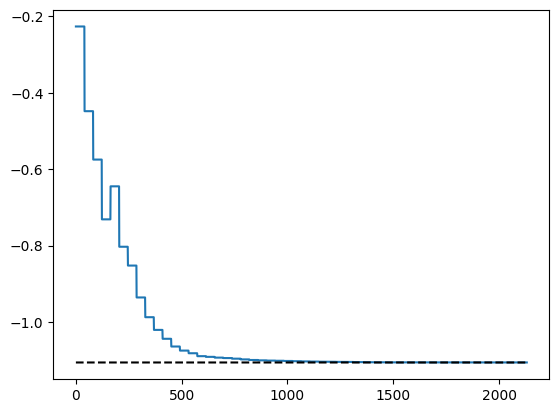

In [58]:
import matplotlib.pyplot as plt
plt.plot(cost_history)
plt.plot(
    range(len(cost_history)),
    [molecule.fci_energy] * len(cost_history),
    linestyle="dashed",
    color="black",
    label="Exact Solution",
)
plt.show()

## Change distance between atoms

In [63]:
def hydrogen_molecule(bond_length):
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    geometry = [["H", [0, 0, 0]], ["H", [0, 0, bond_length]]]
    description = "tmp"
    molecule = of_chem.MolecularData(geometry, basis, multiplicity, charge, description)
    molecule = of_pyscf.run_pyscf(molecule, run_scf=True, run_fci=True)
    n_qubit = molecule.n_qubits
    n_electron = molecule.n_electrons
    fermionic_hamiltonian = of_trans.get_fermion_operator(
        molecule.get_molecular_hamiltonian()
    )
    jw_hamiltonian = of_trans.jordan_wigner(fermionic_hamiltonian)
    return openfermion_to_qamomile(jw_hamiltonian), molecule.fci_energy

bond_lengths = np.linspace(0.2, 1.5, 15)
energies = []
for bond_length in bond_lengths:
    hamiltonian, fci_energy = hydrogen_molecule(bond_length)
    
    ansatz = create_efficient_su2_circuit(
        hamiltonian.num_qubits, rotation_blocks=["ry", "rz"],
        reps=4, entanglement="linear"
    )

    qk_ansatz = qk_transpiler.transpile_circuit(ansatz)
    qk_hamiltonian = qk_transpiler.transpile_hamiltonian(hamiltonian)

    cost_history = []
    initial_params = np.random.uniform(0, np.pi, len(qk_ansatz.parameters))
    result = minimize(
        cost_estimator,
        initial_params,
        method="BFGS",
        options={"maxiter": 50, "gtol": 1e-6},
    )

    energies.append(result.fun)

    print("distance: ", bond_length, "energy: ", result.fun, "fci_energy: ", fci_energy)

distance:  0.2 energy:  0.15756158860921943 fci_energy:  0.15748213479836348
distance:  0.29285714285714287 energy:  -0.5678689994570123 fci_energy:  -0.5679447209710022
distance:  0.38571428571428573 energy:  -0.8833596635475836 fci_energy:  -0.8833596636183383
distance:  0.4785714285714286 energy:  -1.0335786850563213 fci_energy:  -1.0336011797110967
distance:  0.5714285714285714 energy:  -1.1039655751837438 fci_energy:  -1.1042094222435161
distance:  0.6642857142857144 energy:  -1.1323399928249736 fci_energy:  -1.132350882707551
distance:  0.7571428571428571 energy:  -1.1368937721222516 fci_energy:  -1.1369026717971324
distance:  0.8500000000000001 energy:  -1.128198624765488 fci_energy:  -1.1283618784581124
distance:  0.9428571428571428 energy:  -1.1126922136403834 fci_energy:  -1.1127252078468768
distance:  1.0357142857142858 energy:  -1.0929857893199537 fci_energy:  -1.0934760882294043
distance:  1.1285714285714286 energy:  -1.072753746303998 fci_energy:  -1.0727578805453502
dist

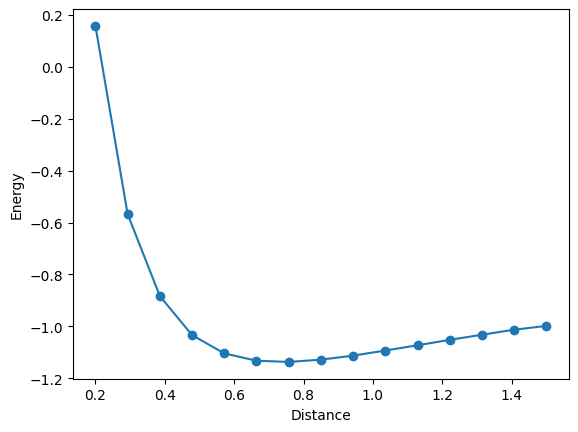

In [67]:
plt.plot(bond_lengths, energies, "-o")
plt.xlabel("Distance")
plt.ylabel("Energy")
plt.show()